In [52]:
#1.import the necessary Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [28]:
data_train=pd.read_csv('train_iot.csv')

In [29]:
data_test=pd.read_csv('test_iot.csv')

In [30]:
data_train.head()

,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041


In [31]:
data_test.head()

,DateTime,Junction,ID
0,2017-07-01 00:00:00,1,20170701001
1,2017-07-01 01:00:00,1,20170701011
2,2017-07-01 02:00:00,1,20170701021
3,2017-07-01 03:00:00,1,20170701031
4,2017-07-01 04:00:00,1,20170701041


In [32]:
data_train.isna().sum()

DateTime    0
Junction    0
Vehicles    0
ID          0
dtype: int64

In [33]:
data_test.isna().sum()

DateTime    0
Junction    0
ID          0
dtype: int64

In [34]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48120 entries, 0 to 48119
Data columns (total 4 columns):
DateTime    48120 non-null object
Junction    48120 non-null int64
Vehicles    48120 non-null int64
ID          48120 non-null int64
dtypes: int64(3), object(1)
memory usage: 1.5+ MB


In [35]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11808 entries, 0 to 11807
Data columns (total 3 columns):
DateTime    11808 non-null object
Junction    11808 non-null int64
ID          11808 non-null int64
dtypes: int64(2), object(1)
memory usage: 276.9+ KB


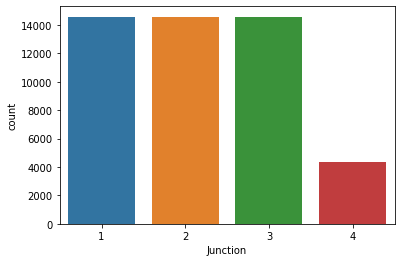

In [36]:
sns.countplot(data_train['Junction'])

In [37]:
data_train['Vehicles'].value_counts()

8      2325
9      2290
7      2220
6      2206
10     2145
       ... 
173       1
141       1
135       1
140       1
127       1
Name: Vehicles, Length: 141, dtype: int64

In [38]:
data_train['ID'].nunique()

48120

In [40]:
data_train['DateTime'] = pd.to_datetime(data_train['DateTime'])
data_test['DateTime'] = pd.to_datetime(data_test['DateTime'])

In [14]:

data_train['Date'] = [d.date() for d in data_train['DateTime']]
data_train['Time'] = [d.time() for d in data_train['DateTime']]
data_test['Date'] = [d.date() for d in data_test['DateTime']]
data_test['Time'] = [d.time() for d in data_test['DateTime']]

In [41]:

def create_features(df, label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['date'] = df.DateTime
    df['hour'] = df['date'].dt.hour
    df['minutes'] = df['date'].dt.minute
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    df['is_month_start'] = (df['date'].dt.is_month_start).astype(int)
    df['is_month_end'] = (df['date'].dt.is_month_end ).astype(int)
    df['is_year_start'] = (df['date'].dt.is_year_start).astype(int)
    df['is_year_end'] = (df['date'].dt.is_year_end).astype(int)
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear','is_year_end','is_year_start','is_month_end','is_month_start']]
    if label:
        y = df[label]
        return X, y
    return X


In [42]:

X, y = create_features(data_train, label='Vehicles')
#X_test = create_features(data)
features_and_target = pd.concat([X, y], axis=1)

In [43]:

features_and_target.head()


,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,is_year_end,is_year_start,is_month_end,is_month_start,Vehicles
0,0,6,4,11,2015,305,1,44,0,0,0,1,15
1,1,6,4,11,2015,305,1,44,0,0,0,1,13
2,2,6,4,11,2015,305,1,44,0,0,0,1,10
3,3,6,4,11,2015,305,1,44,0,0,0,1,7
4,4,6,4,11,2015,305,1,44,0,0,0,1,9


In [44]:

X_test = create_features(data_test)

In [47]:
features_and_target['Junction'] = data_train['Junction']
X_test['Junction'] = data_test['Junction']

In [48]:
y = features_and_target['Vehicles']
X_train = features_and_target.drop("Vehicles",axis=1)

In [49]:
from sklearn.ensemble import BaggingRegressor
from sklearn.model_selection import train_test_split

In [50]:
X_tr,X_val,y_tr,y_val = train_test_split(X_train,y,test_size=0.2,random_state=42)

In [53]:
errlgb = []
y_pred_totxgb = []
fold = KFold(n_splits=5, shuffle=True, random_state=42)
for train_index, test_index in fold.split(X_train):
    X_tr, X_tst = X_train.loc[train_index], X_train.loc[test_index]
    y_tr, y_test = y[train_index], y[test_index]
    br = BaggingRegressor(n_estimators=8)
    br.fit(X_tr,y_tr)
    pred = br.predict(X_tst)
    print(np.sqrt(mean_squared_error(pred,y_test)))
    y_test = br.predict(X_test)
    y_pred_totxgb.append(y_test)

3.74783096559807
3.979923387831101
4.050948913200556
4.276383993607864
4.024969715219885


In [54]:
br.score(X_train,y)

0.9871014619359959

In [55]:
#Tried hist gradient boosting regressor, no luck
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
errlgb = []
y_pred_totxgb = []
fold = KFold(n_splits=5, shuffle=True, random_state=42)
for train_index, test_index in fold.split(X_train):
    X_tr, X_tst = X_train.loc[train_index], X_train.loc[test_index]
    y_tr, y_test = y[train_index], y[test_index]
    br = HistGradientBoostingRegressor(learning_rate=0.01,random_state=42)
    br.fit(X_tr,y_tr)
    pred = br.predict(X_tst)
    print(np.sqrt(mean_squared_error(pred,y_test)))
    y_test = br.predict(X_test)
    y_pred_totxgb.append(y_test)

9.666432131101965
9.668608205269852
10.007766498672583
10.001072086002138
9.998883723683816


In [56]:

final = np.mean(y_pred_totxgb, 0)

In [57]:
sub=pd.read_csv('sample_submission_iot.csv')

In [58]:
sub["Vehicles"] = final

In [59]:

sub.to_csv('submission_br_folds.csv', index=False)

In [15]:
data_train.head()

,DateTime,Junction,Vehicles,ID,Date,Time
0,2015-11-01 00:00:00,1,15,20151101001,2015-11-01,00:00:00
1,2015-11-01 01:00:00,1,13,20151101011,2015-11-01,01:00:00
2,2015-11-01 02:00:00,1,10,20151101021,2015-11-01,02:00:00
3,2015-11-01 03:00:00,1,7,20151101031,2015-11-01,03:00:00
4,2015-11-01 04:00:00,1,9,20151101041,2015-11-01,04:00:00


In [16]:
data_test.head()

,DateTime,Junction,ID,Date,Time
0,2017-07-01 00:00:00,1,20170701001,2017-07-01,00:00:00
1,2017-07-01 01:00:00,1,20170701011,2017-07-01,01:00:00
2,2017-07-01 02:00:00,1,20170701021,2017-07-01,02:00:00
3,2017-07-01 03:00:00,1,20170701031,2017-07-01,03:00:00
4,2017-07-01 04:00:00,1,20170701041,2017-07-01,04:00:00


In [17]:
data_train.drop(['DateTime'], axis=1, inplace=True)

In [18]:
data_test.drop(['DateTime'], axis=1, inplace=True)

In [19]:
data_train

,Junction,Vehicles,ID,Date,Time
0,1,15,20151101001,2015-11-01,00:00:00
1,1,13,20151101011,2015-11-01,01:00:00
2,1,10,20151101021,2015-11-01,02:00:00
3,1,7,20151101031,2015-11-01,03:00:00
4,1,9,20151101041,2015-11-01,04:00:00
...,...,...,...,...,...
48115,4,11,20170630194,2017-06-30,19:00:00
48116,4,30,20170630204,2017-06-30,20:00:00
48117,4,16,20170630214,2017-06-30,21:00:00
48118,4,22,20170630224,2017-06-30,22:00:00


In [20]:
data_test

,Junction,ID,Date,Time
0,1,20170701001,2017-07-01,00:00:00
1,1,20170701011,2017-07-01,01:00:00
2,1,20170701021,2017-07-01,02:00:00
3,1,20170701031,2017-07-01,03:00:00
4,1,20170701041,2017-07-01,04:00:00
...,...,...,...,...
11803,4,20171031194,2017-10-31,19:00:00
11804,4,20171031204,2017-10-31,20:00:00
11805,4,20171031214,2017-10-31,21:00:00
11806,4,20171031224,2017-10-31,22:00:00


In [21]:
final=data_train.append(data_test)

F:\Anaconda\lib\site-packages\pandas\core\frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


In [22]:
final.head()

,Date,ID,Junction,Time,Vehicles
0,2015-11-01,20151101001,1,00:00:00,15.0
1,2015-11-01,20151101011,1,01:00:00,13.0
2,2015-11-01,20151101021,1,02:00:00,10.0
3,2015-11-01,20151101031,1,03:00:00,7.0
4,2015-11-01,20151101041,1,04:00:00,9.0


In [23]:
final.tail()

,Date,ID,Junction,Time,Vehicles
11803,2017-10-31,20171031194,4,19:00:00,NaN
11804,2017-10-31,20171031204,4,20:00:00,NaN
11805,2017-10-31,20171031214,4,21:00:00,NaN
11806,2017-10-31,20171031224,4,22:00:00,NaN
11807,2017-10-31,20171031234,4,23:00:00,NaN


In [24]:
final.corr()

,ID,Junction,Vehicles
ID,1.000000,0.228370,0.227974
Junction,0.228370,1.000000,-0.613787
Vehicles,0.227974,-0.613787,1.000000


C:\Users\HP\Anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\HP\Anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


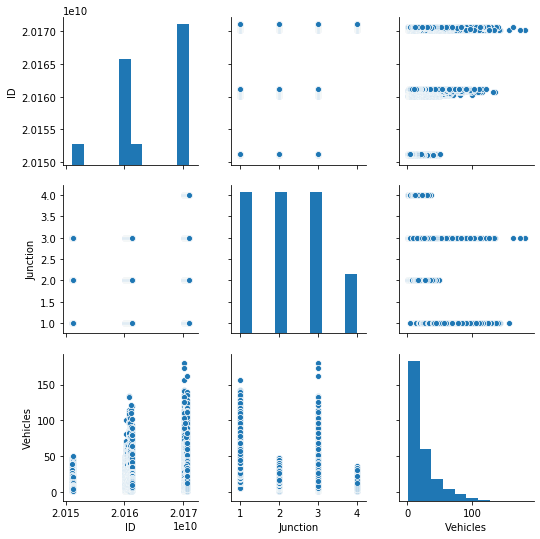

In [25]:
sns.pairplot(final)

Splitting data 

In [26]:
df_Train=final.iloc[:48119,:]
df_Test=final.iloc[48120:,:]

In [27]:
df_Train.shape

(48119, 5)

In [28]:
df_Test.shape

(11808, 5)

In [29]:
y_train=df_Train['Vehicles']

In [30]:
y_train

0        15.0
1        13.0
2        10.0
3         7.0
4         9.0
         ... 
48114    17.0
48115    11.0
48116    30.0
48117    16.0
48118    22.0
Name: Vehicles, Length: 48119, dtype: float64

In [31]:
X_train=df_Train.drop(['Vehicles','Date','Time'],axis=1)

X_train.head(10)

,ID,Junction
0,20151101001,1
1,20151101011,1
2,20151101021,1
3,20151101031,1
4,20151101041,1
5,20151101051,1
6,20151101061,1
7,20151101071,1
8,20151101081,1
9,20151101091,1


In [32]:
y_test=df_Test['Vehicles']

In [33]:
X_test=df_Test.drop(['Vehicles','Date','Time'],axis=1)

X_test.head(10)

,ID,Junction
0,20170701001,1
1,20170701011,1
2,20170701021,1
3,20170701031,1
4,20170701041,1
5,20170701051,1
6,20170701061,1
7,20170701071,1
8,20170701081,1
9,20170701091,1


In [56]:
# Import Linear Regression machine learning library
from sklearn.tree import DecisionTreeRegressor

In [57]:
regressor = DecisionTreeRegressor(random_state=0, max_depth=3)

regressor.fit(X_train , y_train)

DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=0, splitter='best')

In [74]:
# Fitting Random Forest Regression to the dataset 
# import the regressor 
from sklearn.ensemble import RandomForestRegressor 
  
 # create regressor object 
regressor = RandomForestRegressor(n_estimators = 100, random_state = 0) 
  
# fit the regressor with x and y data 
regressor.fit(X_train , y_train)   

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=0, verbose=0,
                      warm_start=False)

In [34]:
from xgboost import XGBClassifier
xgb = XGBClassifier(n_esttimators=500, max_depth=4, scale_pos_weight=10)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_esttimators=500, n_jobs=0,
              num_parallel_tree=1, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=10, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)

In [36]:
y_pred=xgb.predict(X_test)
y_pred

array([96., 96., 96., ..., 16., 16., 16.])

In [75]:
y_pred = regressor.predict(X_test)
y_pred

array([92.49885631, 92.49885631, 92.49885631, ..., 17.39722036,
       17.39722036, 17.39722036])

In [58]:
y_pred = regressor.predict(X_test)

In [59]:
y_pred

array([65.96477101, 65.96477101, 65.96477101, ...,  7.25051808,
        7.25051808,  7.25051808])

In [37]:
y_test.fillna(0,inplace=True)

C:\Users\HP\Anaconda3\lib\site-packages\pandas\core\generic.py:6287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [38]:

#Evaluation
import math
from sklearn.metrics import mean_squared_log_error
MSE=mean_squared_log_error(y_test, y_pred)

In [39]:
RMSE=math.sqrt(MSE)

In [40]:
RMSE

3.6608367751126636

In [41]:
sub=df_Test['ID']

In [42]:
submission=pd.DataFrame(sub)

In [43]:
Vehicles=pd.DataFrame(y_pred)

In [44]:
sub=pd.read_csv('sample_submission_iot.csv')

In [45]:
sub.shape

(11808, 2)

In [46]:
datasets=pd.concat([sub['ID'],Vehicles],axis=1)

In [47]:
datasets.shape

(11808, 2)

In [48]:
datasets.columns=['ID','Vehicles']

In [50]:

datasets.to_csv('submission_iottt.csv',index=False)